<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkST0151ENSkillsNetwork20531532-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>



#### Import the required libraries we need for the lab.


In [1]:
import piplite
await piplite.install(['numpy'],['pandas'])
await piplite.install(['seaborn'])

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pyplot
import scipy.stats
from scipy.stats import zscore
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from math import ceil
from datetime import date

#### Read the dataset in the csv file from the URL


In [3]:
from js import fetch
import io

URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ST0151EN-SkillsNetwork/labs/boston_housing.csv'
resp = await fetch(URL)
boston_url = io.BytesIO((await resp.arrayBuffer()).to_py())

In [4]:
boston_df=pd.read_csv(boston_url)

#### Add your code below following the instructions given in the course to complete the peer graded assignment


# task 1: explore dataset

In [5]:
# display first few rows
print(boston_df.head())

   Unnamed: 0     CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  \
0           0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0   
1           1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0   
2           2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0   
3           3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0   
4           4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0   

     TAX  PTRATIO  LSTAT  MEDV  
0  296.0     15.3   4.98  24.0  
1  242.0     17.8   9.14  21.6  
2  242.0     17.8   4.03  34.7  
3  222.0     18.7   2.94  33.4  
4  222.0     18.7   5.33  36.2  


In [6]:
# check data types
print(boston_df.info())

# check missing vals
missing_val = boston_df.isnull().sum()
if not missing_val[missing_val > 0].empty: 
    print(f'Missing values: {missing_val[missing_val > 0]}')
else: 
    print('No missing values in any col of boston_df.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   CRIM        506 non-null    float64
 2   ZN          506 non-null    float64
 3   INDUS       506 non-null    float64
 4   CHAS        506 non-null    float64
 5   NOX         506 non-null    float64
 6   RM          506 non-null    float64
 7   AGE         506 non-null    float64
 8   DIS         506 non-null    float64
 9   RAD         506 non-null    float64
 10  TAX         506 non-null    float64
 11  PTRATIO     506 non-null    float64
 12  LSTAT       506 non-null    float64
 13  MEDV        506 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 55.4 KB
None
No missing values in any col of boston_df.


First column is not needed and can be dropped.<br>
CHAS is a dummy variabel, indicating if a tract bounds river, change format from float to categorys.<br>
Since there are no missing values, this must not be addressed.<br>

In [94]:
# drop column 'Unnamed: 0'
boston_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# change format of CHAS (1 if tract bounds river; 0 otherwise)
boston_df['CHAS'] = boston_df['CHAS'].astype('category')

In [27]:
# add age categories
## discretize the age variable into three groups of 35 years and younger, between 35 and 70 years and 70 years and older
current_year = date.today().year
boston_df['DISCRETIZED_AGE'] = pd.cut(boston_df['AGE'], bins=[-np.inf, 35, 69.9, np.inf], labels=['35 years and younger', 'between 35 and 70 years', '70 years and older'])

In [102]:
# define numeric variables
numeric_vars = list(boston_df.select_dtypes(include=['float64']).columns)
print(f'Numeric variables: {numeric_vars}.')

# define categorical variables
categorical_vars = list(set(boston_df.columns).difference(set(numeric_vars)))
print(f'Categorical variables: {categorical_vars}')

Numeric variables: ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV'].
Categorical variables: ['CHAS', 'DISCRETIZED_AGE']


# task 2: descriptive statistic & visualizations

## numeric variables

In [29]:
# descriptive statistics
print(boston_df[numeric_vars].describe())

             CRIM          ZN       INDUS         NOX          RM         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.554695    6.284634   68.574901   
std      8.601545   23.322453    6.860353    0.115878    0.702617   28.148861   
min      0.006320    0.000000    0.460000    0.385000    3.561000    2.900000   
25%      0.082045    0.000000    5.190000    0.449000    5.885500   45.025000   
50%      0.256510    0.000000    9.690000    0.538000    6.208500   77.500000   
75%      3.677083   12.500000   18.100000    0.624000    6.623500   94.075000   
max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   

              DIS         RAD         TAX     PTRATIO       LSTAT        MEDV  
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000  
mean     3.795043    9.549407  408.237154   18.455534   12.653063   22.532806  
std      2.105710    8.707259 

### task 2a) For the "Median value of owner-occupied homes" provide a boxplot

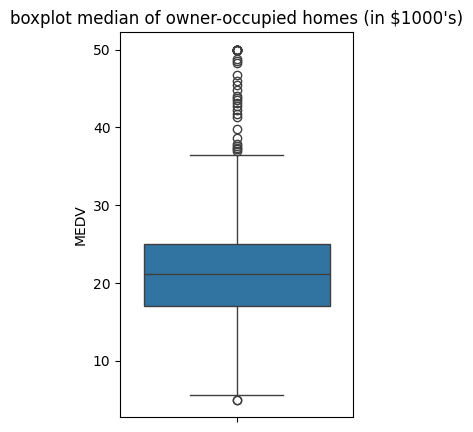

In [46]:
# For the "Median value of owner-occupied homes" provide a boxplot
pyplot.figure(figsize=(3, 5))
sns.boxplot(data=boston_df['MEDV'])
pyplot.title('''boxplot median of owner-occupied homes (in $1000's)''')
pyplot.show()

The median of MEDV is USD 21'200, i.e. half of the homes occupied by owners are have more then  USD 21'200 in value.<br>
The 25%- and 75%-percentiles are quite narrow at USD 17'025 and USD 25'000 respectively.<br>
However, the MEDV variable has quite a few outlier on the upper end, i.e. there are quite a few towns where more than 50% of owner occupied homes are higher valued.<br>
The max is at USD 50'000, i.e. in this town, more than 50% of owner occupied homes have woth USD 50'000 or more.<br>

### task 2c) Provide a boxplot for the MEDV variable vs the discretized AGE variable

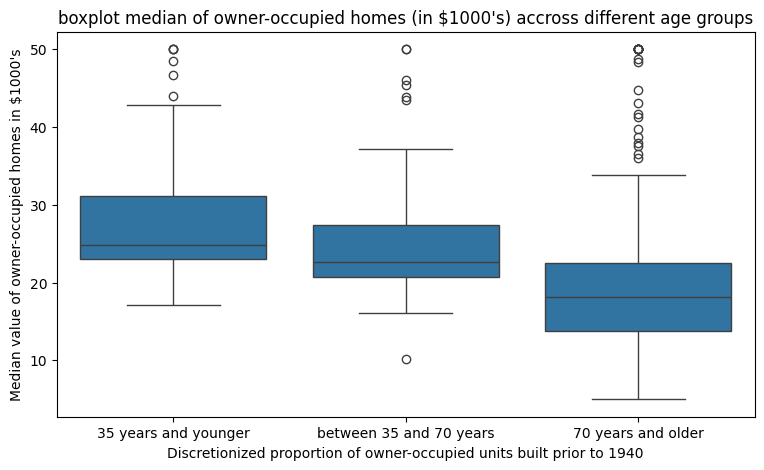

In [51]:
# Discretize the age variable into three groups of 35 years and younger, between 35 and 70 years and 70 years and older
pyplot.figure(figsize=(9, 5))
sns.boxplot(x='DISCRETIZED_AGE', y='MEDV', data=boston_df).set(
    xlabel='Discretionized proportion of owner-occupied units built prior to 1940', 
    ylabel='''Median value of owner-occupied homes in $1000's'''
)
pyplot.title('''boxplot median of owner-occupied homes (in $1000's) accross different age groups''')
pyplot.show()

Expectedly, the median and all other measures of dispersion are decreasing for older categories, i.e. the higher the share of older homes in the respective categoriy, the lower are the measures of dispersion.<br>

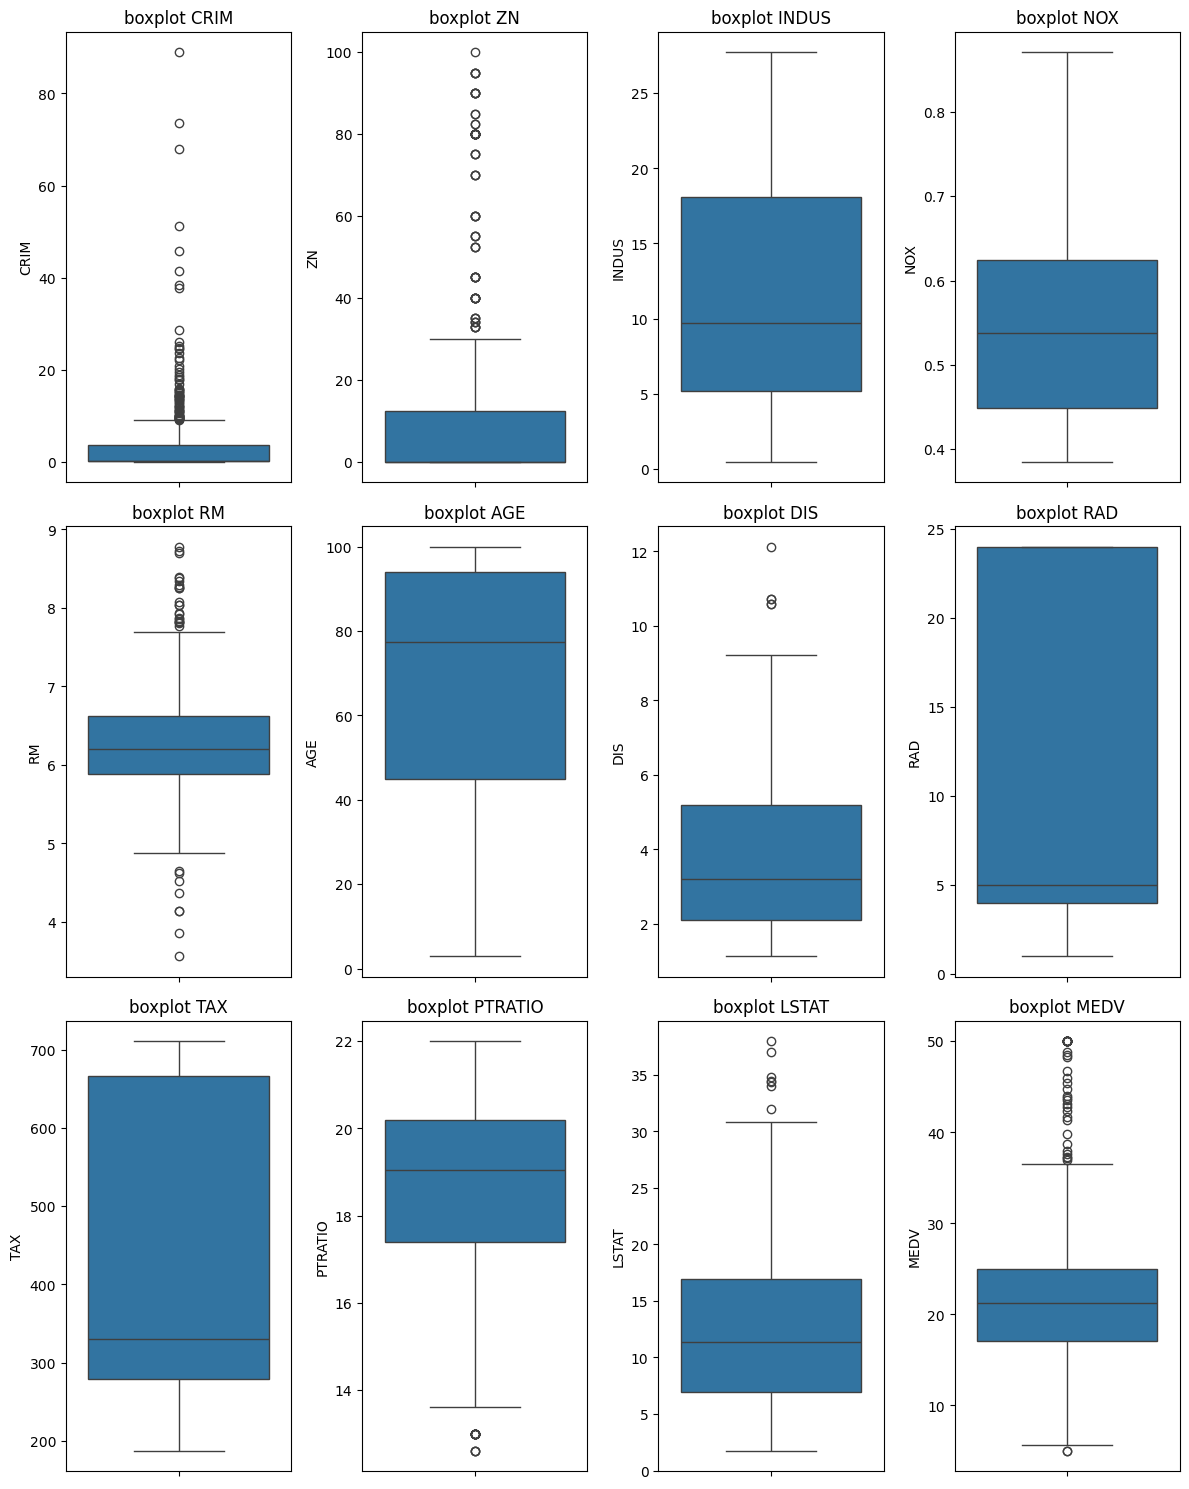

In [52]:
# additional boxplots to visualize dispersion of values for all other numerical variables
pyplot.figure(figsize=(12, 15))
for i, var in enumerate(numeric_vars, 1):
    pyplot.subplot(3, ceil(len(numeric_vars)/3), i)
    sns.boxplot(data=boston_df[var])
    pyplot.title(f'boxplot {var}')
    
pyplot.tight_layout()
pyplot.show()

### task 2e) Create a histogram for the pupil to teacher ratio variable

In [67]:
mode = boston_df['PTRATIO'].mode()
print( mode)

0    20.2
Name: PTRATIO, dtype: float64


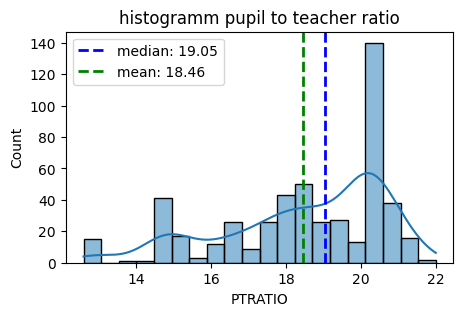

In [69]:
pyplot.figure(figsize=(5, 3))
sns.histplot(boston_df['PTRATIO'], bins=20, kde=True)
pyplot.title(f'histogramm pupil to teacher ratio')

## add median an mean lines
med = boston_df['PTRATIO'].median()
mean = boston_df['PTRATIO'].mean()
pyplot.axvline(med, color='blue', linestyle='dashed', linewidth=2, label=f'median: {med:.2f}')
pyplot.axvline(mean, color='green', linestyle='dashed', linewidth=2, label=f'mean: {mean:.2f}')
pyplot.legend()

The pupil to teacher ration is not normally distributed but left-skewed with mean < median.<br>

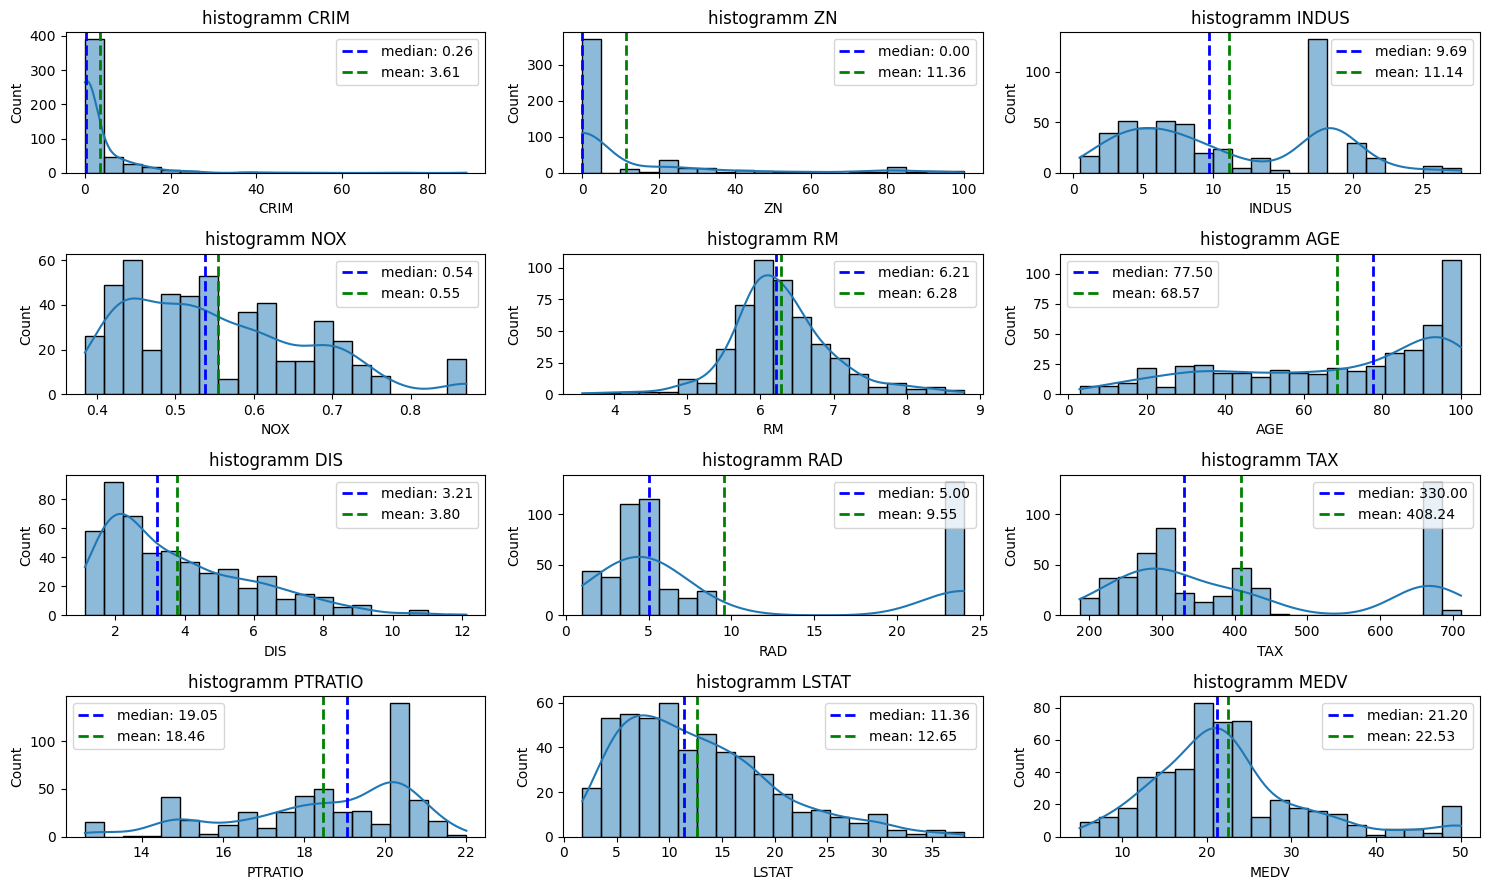

In [71]:
# additional histograms for all other numerical variables
pyplot.figure(figsize=(15, 9))
for i, var in enumerate(numeric_vars, 1):
    pyplot.subplot(ceil(len(numeric_vars)/3), 3, i)
    sns.histplot(boston_df[var], bins=20, kde=True)
    pyplot.title(f'histogramm {var}')
    
    ## add median an mean lines
    med = boston_df[var].median()
    mean = boston_df[var].mean()
    pyplot.axvline(med, color='blue', linestyle='dashed', linewidth=2, label=f'median: {med:.2f}')
    pyplot.axvline(mean, color='green', linestyle='dashed', linewidth=2, label=f'mean: {mean:.2f}')
    pyplot.legend()

pyplot.tight_layout()
pyplot.show()

RM is normally distributed. All other variables are skewed and have outlier.<br>

### task 2d) Provide a scatter plot to show the relationship between Nitric oxide concentrations and the proportion of non-retail business acres per town. What can you say about the relationship?

Text(0.75, 0.9, 'correlation: 0.76\np-value: 0.0000')

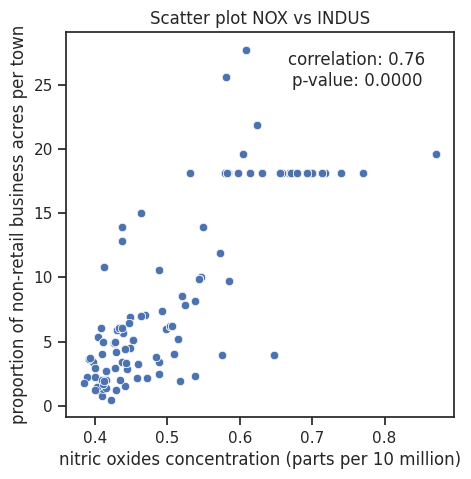

In [138]:
pyplot.figure(figsize=(5, 5))
sns.set(style='ticks')
sns.scatterplot(x='NOX', y='INDUS', data=boston_df).set(
    xlabel='nitric oxides concentration (parts per 10 million)',
    ylabel='proportion of non-retail business acres per town'
)
pyplot.title('Scatter plot NOX vs INDUS')

# calculate correlation and p-value and annotate plot
pearson_corr = pearsonr(boston_df['NOX'], boston_df['INDUS'])
pyplot.annotate(f'correlation: {pearson_corr[0]:.2f}\np-value: {pearson_corr[1]:.4f}',
                xy=(0.75, 0.9),
                xycoords='axes fraction',
                ha='center', va='center')

The nitrix oxide concentration and the proportion of non-retail business acres are strongly positive correlated.<br>
That is higher nitrix oxide concentration goes in hand with higher non-retail business acres per town.<br>

<Figure size 2000x2000 with 0 Axes>

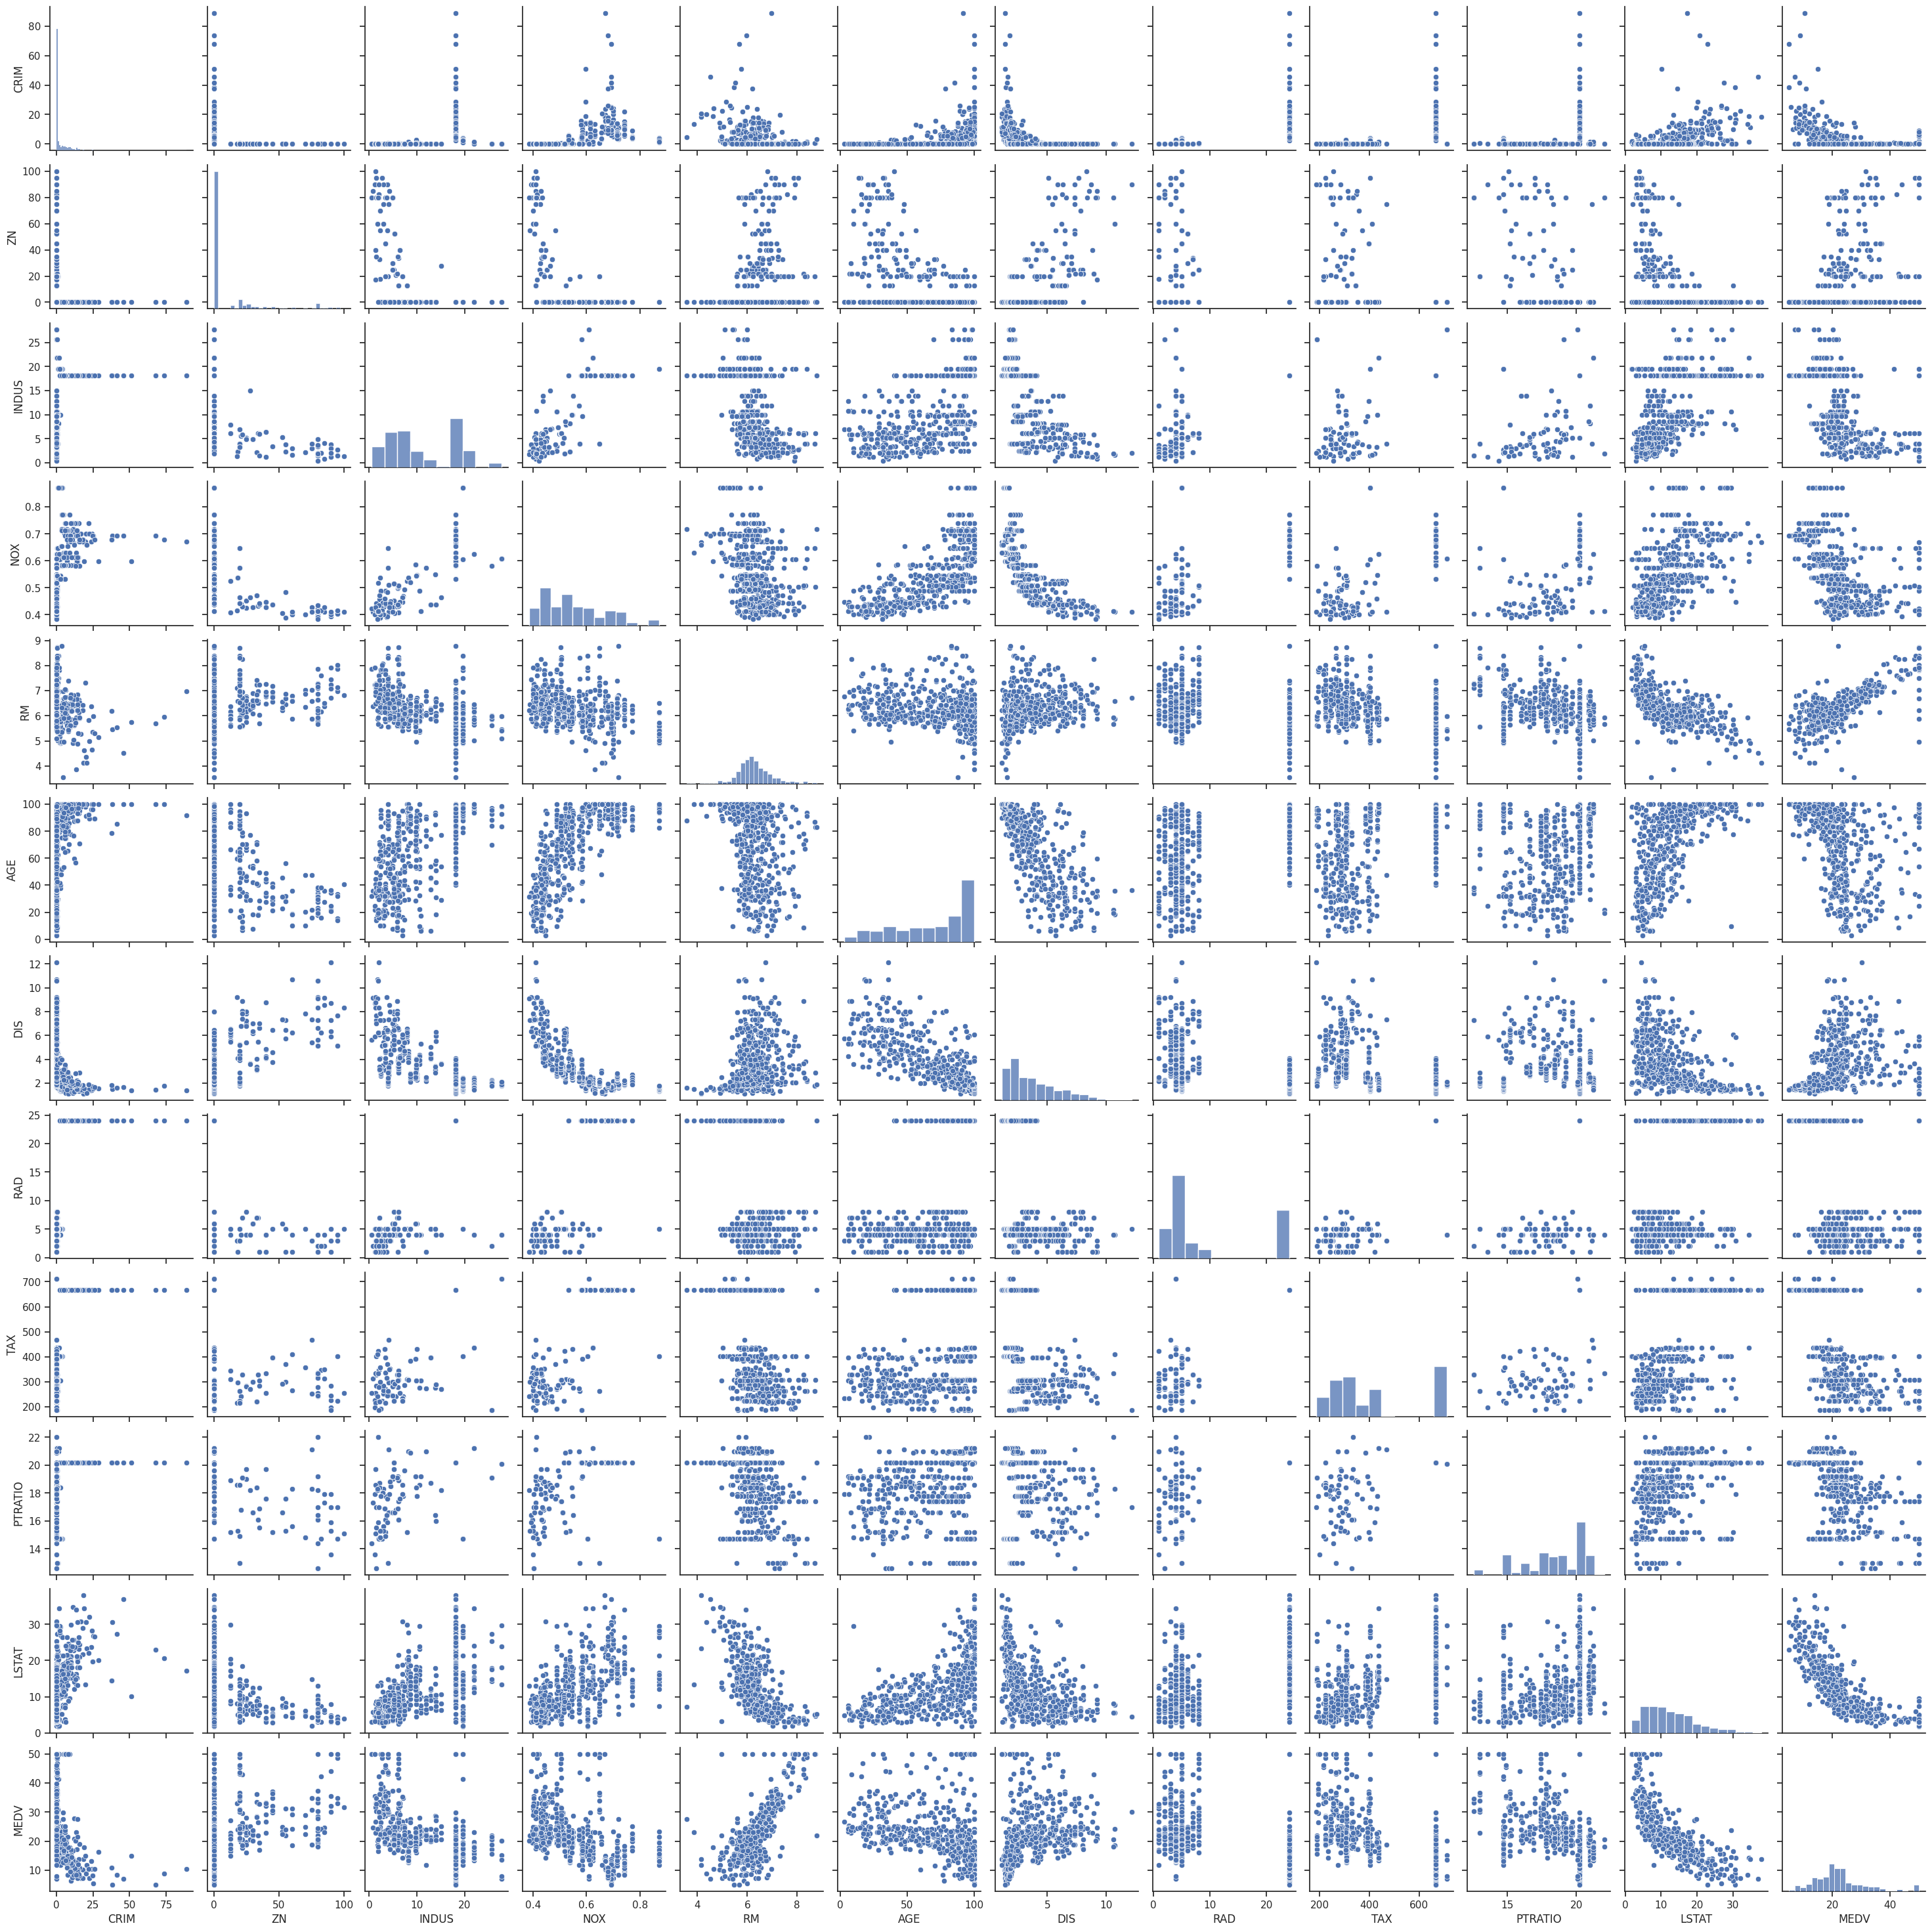

In [89]:
# additional pairwise scatter plots to visualize relations of all numerical variables
pyplot.figure(figsize=(20, 20))
sns.set(style='ticks')
sns.pairplot(boston_df[numeric_vars])

<AxesSubplot:>

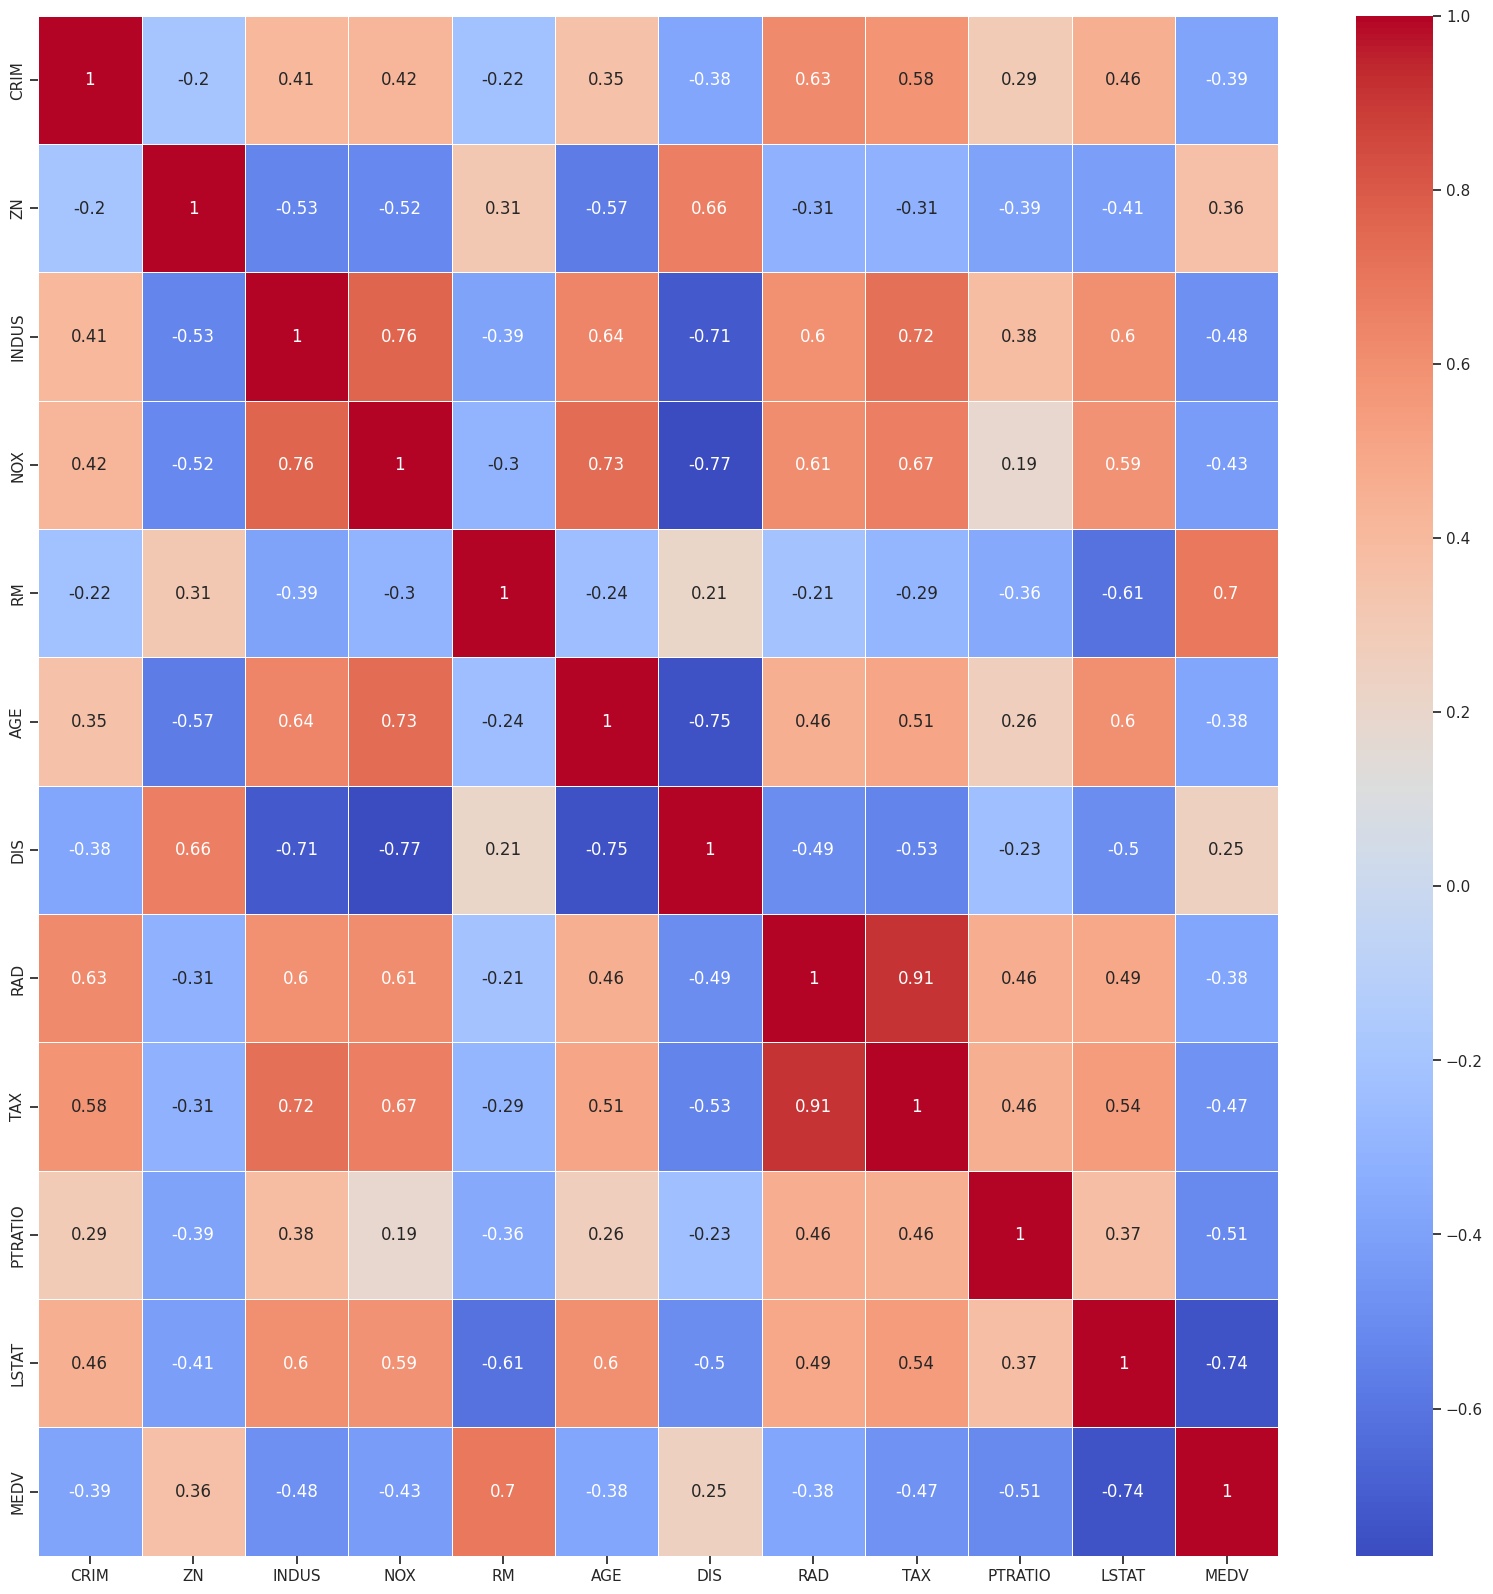

In [93]:
# pairwise correlation heatmap
pyplot.figure(figsize=(20, 20))
correlation_matrix = boston_df[numeric_vars].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidth=0.5)

## categorical variables

In [103]:
# relative & absolute count per category
for var in categorical_vars:
    print(boston_df[var].value_counts())
    print(boston_df[var].value_counts(normalize=True))

0.0    471
1.0     35
Name: CHAS, dtype: int64
0.0    0.93083
1.0    0.06917
Name: CHAS, dtype: float64
70 years and older         287
between 35 and 70 years    128
35 years and younger        91
Name: DISCRETIZED_AGE, dtype: int64
70 years and older         0.567194
between 35 and 70 years    0.252964
35 years and younger       0.179842
Name: DISCRETIZED_AGE, dtype: float64


### task 2b) Provide a  bar plot for the Charles river variable

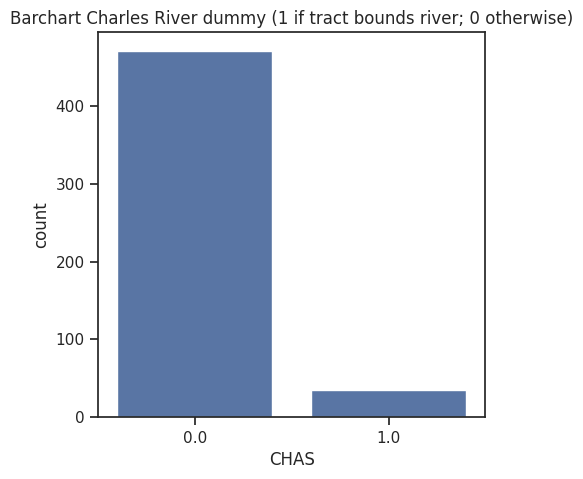

In [106]:
pyplot.figure(figsize=(5, 5))
sns.countplot(x='CHAS', data=boston_df)
pyplot.title(f'Barchart Charles River dummy (1 if tract bounds river; 0 otherwise)')
pyplot.show()

There are way more towns that do not tract the Charles River (471, 93%) than town that tract bounds river (35, 7%).<br>

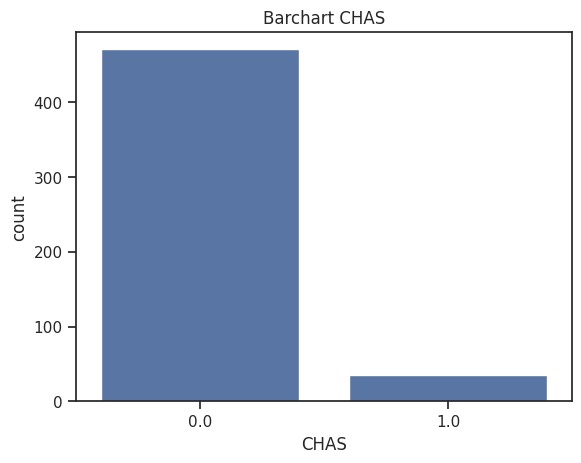

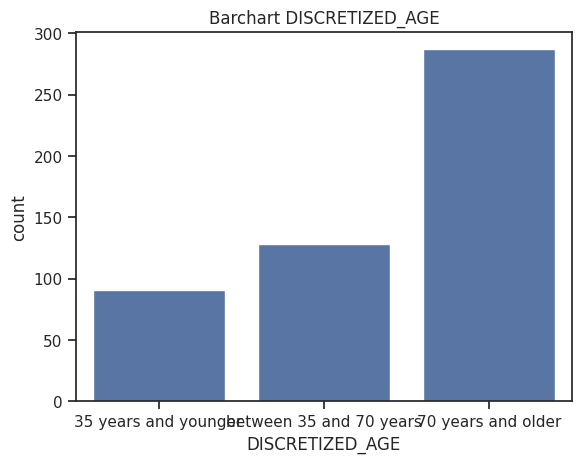

In [107]:
# bar chart for all categorical variables
for var in categorical_vars:
    sns.countplot(x=var, data=boston_df)
    pyplot.title(f'Barchart {var}')
    pyplot.show()

## task 3: Use the appropriate tests to answer the questions provided.

In [116]:
# Significance level: α = 0.05
alpha = 0.05

### taks 3a) Is there a significant difference in median value of houses bounded by the Charles river or not? (T-test for independent samples)

**Hypothesis**<br>
H0: µ1=µ2 ("there is no difference in median value of houses bounded by the Charles river")<br>
H1: µ1≠µ2 ("there is a difference in median value of houses bounded by the Charles river")<br>

In [113]:
# describe MEDV per category
boston_df.groupby('CHAS')['MEDV'].describe()

,count,mean,std,min,25%,50%,75%,max
CHAS,,,,,,,,
0.0,471.0,22.093843,8.831362,5.0,16.6,20.9,24.80,50.0
1.0,35.0,28.440000,11.816643,13.4,21.1,23.3,33.15,50.0


In [123]:
# perform a t-test to test the difference of means
t_test = scipy.stats.ttest_ind(boston_df[boston_df['CHAS']==1]['MEDV'], boston_df[boston_df['CHAS']==0]['MEDV'])
print(f'{t_test}\n')

# conclusion
if t_test[1] <= alpha:
    print(f'Conclusion:\nP-value {t_test[1]:.4f} <= significance level {alpha:.2f}.\n'
          'H0: µ1=µ2 is rejected, H1: µ1≠µ2 is accepted.\n'
          'There is a significant difference in median value of houses bounded by the Charles river.')
else:
    print(f'Conclusion:\nP-value {t_test[1]:.4f} > significance level {alpha:.2f}.\n'
          'H0: µ1=µ2 cannot be rejected.\n' 
          'There is no difference in median value of houses bounded by the Charles river.')

TtestResult(statistic=3.996437466090509, pvalue=7.390623170519905e-05, df=504.0)

Conclusion:
P-value 0.0001 <= significance level 0.05.
H0: µ1=µ2 is rejected, H1: µ1≠µ2 is accepted.
There is a significant difference in median value of houses bounded by the Charles river.


**Conclusion**<br>
The t-test on difference of means yields a p-value of 0.0001.<br>
This is below the significance level of 5%.<br>
Consequently, H0: µ1=µ2 is rejected and H1: µ1≠µ2 is accepted.<br>
We conclude, there is a significant difference in median value of houses bounded by the Charles river.<br>

### task 3b) Is there a difference in Median values of houses (MEDV) for each proportion of owner occupied units built prior to 1940 (AGE)? (ANOVA)

**Hypothesis**<br>
H0: µ1=µ2=µ3 ("there is no difference in median value of houses for each proportion of owner occupied units built prior to 1940 (AGE)")<br>
H1: at least one mean is different from the others ("there is a difference in median value of houses for each proportion of owner occupied units built prior to 1940 (AGE)")<br>

In [132]:
# describe MEDV per category
boston_df.groupby('DISCRETIZED_AGE')['MEDV'].describe()

,count,mean,std,min,25%,50%,75%,max
DISCRETIZED_AGE,,,,,,,,
35 years and younger,91.0,27.775824,7.638198,17.1,23.050,24.8,31.150,50.0
between 35 and 70 years,128.0,24.947656,6.969370,10.2,20.675,22.6,27.425,50.0
70 years and older,287.0,19.793380,9.515375,5.0,13.800,18.2,22.550,50.0


In [125]:
# levene test on equality of variances
scipy.stats.levene(boston_df[boston_df['DISCRETIZED_AGE'] == '35 years and younger']['MEDV'],
                   boston_df[boston_df['DISCRETIZED_AGE'] == 'between 35 and 70 years']['MEDV'], 
                   boston_df[boston_df['DISCRETIZED_AGE'] == '70 years and older']['MEDV'], 
                   center='mean')

LeveneResult(statistic=2.7806200293748304, pvalue=0.06295337343259205)

Levene test yields p-value of 0.0630 > 0.05.<br>
H0 connot be rejected, which supports the assumption of equal variances accross all groups.<br>
We can continue with our ANOVA test on the difference of means.<br>

In [133]:
anova = scipy.stats.f_oneway(
    boston_df[boston_df['DISCRETIZED_AGE'] == '35 years and younger']['MEDV'],
    boston_df[boston_df['DISCRETIZED_AGE'] == 'between 35 and 70 years']['MEDV'], 
    boston_df[boston_df['DISCRETIZED_AGE'] == '70 years and older']['MEDV'])
print(f'F-statistic: {anova[0]}, p-value: {anova[1]}.\n')

# conclusion
if anova[1] <= alpha:
    print(f'Conclusion:\nP-value {anova[1]:.4f} <= significance level {alpha:.2f}.\n'
          'H0: µ1=µ2=µ3 is rejected, H1 is accepted.\n'
          'There is a difference in median value of houses for each proportion of owner occupied units built prior to 1940 (AGE).')
else:
    print(f'Conclusion:\nP-value {anova[1]:.4f} > significance level {alpha:.2f}.\n'
          'H0: µ1=µ2=µ3 cannot be rejected.\n' 
          'There is no difference in median value of houses for each proportion of owner occupied units built prior to 1940 (AGE).')

F-statistic: 36.40764999196599, p-value: 1.7105011022702984e-15.

Conclusion:
P-value 0.0000 <= significance level 0.05.
H0: µ1=µ2=µ3 is rejected, H1 is accepted.
There is a difference in median value of houses for each proportion of owner occupied units built prior to 1940 (AGE).


**Conclusion**<br>
The one way ANOVA yields a p-value that is below the significance level of 5%.<br>
Consequently, H0: µ1=µ2=µ3 is rejected and H1 is accepted.<br>
We conclude, there is a significant difference in median value of houses for each proportion of owner occupied units built prior to 1940 (AGE).<br>

### task 3c) Can we conclude that there is no relationship between Nitric oxide concentrations and proportion of non-retail business acres per town? (Pearson Correlation)

**Hypothesis**<br>
H0: there is no relationship between Nitric oxide concentrations and proportion of non-retail business acres per town<br>
H1: there is a relationship between Nitric oxide concentrations and proportion of non-retail business acres per town<br>

In [142]:
# pearson correlation was computed in task 2d (see above)
print(f'Pearson correlation coefficient: {pearson_corr[0]}, p-value: {pearson_corr[1]}.\n')

# conclusion
if pearson_corr[1] <= alpha:
    print(f'Conclusion:\nP-value {pearson_corr[1]:.4f} <= significance level {alpha:.2f}.\n'
          'H0: is rejected, H1 is accepted.\n'
          'There is a relationship between Nitric oxide concentrations and proportion of non-retail business acres per town.')
else:
    print(f'Conclusion:\nP-value {pearson_corr[1]:.4f} > significance level {alpha:.2f}.\n'
          'H0: cannot be rejected.\n' 
          'There is no relationship between Nitric oxide concentrations and proportion of non-retail business acres per town.')

Pearson correlation coefficient: 0.7636514469209192, p-value: 7.913361061210442e-98.

Conclusion:
P-value 0.0000 <= significance level 0.05.
H0: is rejected, H1 is accepted.
There is a relationship between Nitric oxide concentrations and proportion of non-retail business acres per town.


**Conclusion**<br>
The p-value of the pearson correlation is below the significance level of 5%.<br>
Consequently, H0 is rejected and H1 is accepted.<br>
We conclude, there exists a relationship between Nitric oxide concentrations and proportion of non-retail business acres per town.<br>

### task 3d) What is the impact of an additional weighted distance  to the five Boston employment centres on the median value of owner occupied homes? (Regression analysis)

**Hypothesis**<br>
H0: β1=0 ("there is no impact of an additional weighted distance to the five Boston employment centres on the median value of owner occupied homes")<br>
H1: β1≠0 ("there is an impact of an additional weighted distance to the five Boston employment centres on the median value of owner occupied homes")<br>

In [146]:
# define the target variable
y = boston_df['MEDV']

# define input variable
x = boston_df['DIS']

# add constant, i.e. intercept (β0)
x = sm.add_constant(x)

# build a simple univariate linear model
model = sm.OLS(y, x).fit()

# model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.58
Date:                Sun, 10 Mar 2024   Prob (F-statistic):           1.21e-08
Time:                        14:01:43   Log-Likelihood:                -1823.9
No. Observations:                 506   AIC:                             3652.
Df Residuals:                     504   BIC:                             3660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3901      0.817     22.499      0.000      16.784      19.996
DIS            1.0916      0.188      5.795      0.000       0.722       1.462
==============================================================================
Omnibus:                      139.779   Durbin-Watson:                   0.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.104
Skew:                           1.466   Prob(JB):                     5.59e-67
Kurtosis:                       5.424   Cond. No.                         9.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusion**<br>
The p-value for the coefficint of DIS, β1 (0.000), is below the significance level of 5%.<br>
Consequently, H0: β1=0 is rejected and H1: β1≠0 is accepted.<br>
We conclude, there is a significantly positive impact of an additional weighted distance to the five Boston employment centres on the median value of owner occupied homes.<br>